# Background

The documentation if as follows:

- [Prophet for Python](https://facebook.github.io/prophet/docs/quick_start.html)

In [44]:
import requests
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Data

The data is coming from the State of California. The goal was to get population data; however, this was not downloadable. However, [admissions and releases data](https://data.ca.gov/dataset/monthly-admissions-and-releases/resource/ae96772a-4e4d-4084-a759-7661758361e6) was also available, it will do!

Begin by pulling the data using the public API. From there, serialize the data as a JSON and from there unnest the data by extracting the appropriate values.

In [4]:
url = "https://data.ca.gov/api/3/action/datastore_search?resource_id=ae96772a-4e4d-4084-a759-7661758361e6"
res = requests.get(url).json()['result']['records']

Transform the data to a Pandas DataFrame and take a quick look:

In [5]:
df = pd.DataFrame.from_dict(res)
df.head()

,Date,YearlyNetChange,TotalAdmissions,_id,TotalReleases
0,1/31/2014,28,3006,1,2945
1,2/28/2014,28,3139,2,2715
2,3/31/2014,28,3269,3,3144
3,4/30/2014,28,3421,4,3347
4,5/31/2014,28,3773,5,3203


The input to Prophet is always a DataFrame with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast. 

This means that we have make some edits to the existing data:

In [36]:
df['ds'] = pd.to_datetime(df['Date'])
df['TotalAdmissions'] = pd.to_numeric(df['TotalAdmissions'])
df['TotalReleases'] = pd.to_numeric(df['TotalReleases'])
df['y'] = pd.to_numeric(df['TotalAdmissions'])

Plot the data just to get a sense of what we are working with:

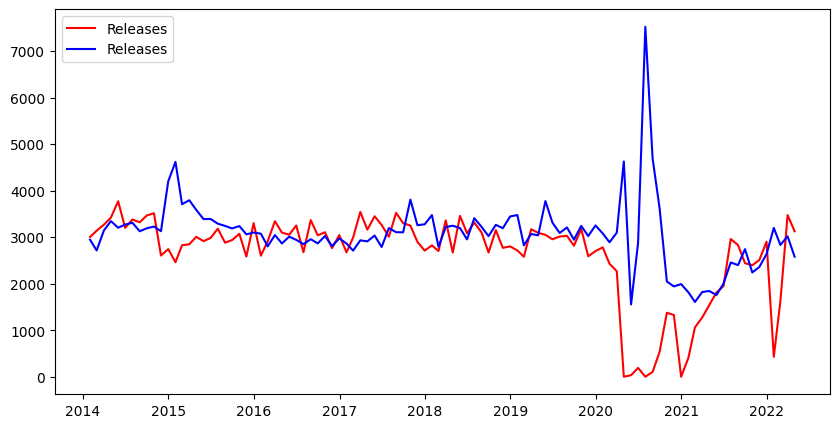

In [50]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['ds'], df['y'], color = "red", label = "Admissions");
ax.plot(df['ds'], df['TotalReleases'], color = "blue", label = "Releases");
ax.legend(loc="upper left");

# Fit the Model

With the data ready, fit the model by instantiating a new `Prophet` object. Begin by splitting a training and testing set:

In [86]:
# https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split
train_percent = 0.80
time_range = df.ds.max() - df.ds.min()
train_cutoff = df.ds.min() + train_percent*time_range

train_df = df[df.ds <= train_cutoff]
test_df = df[df.ds > train_cutoff]

Take a look:

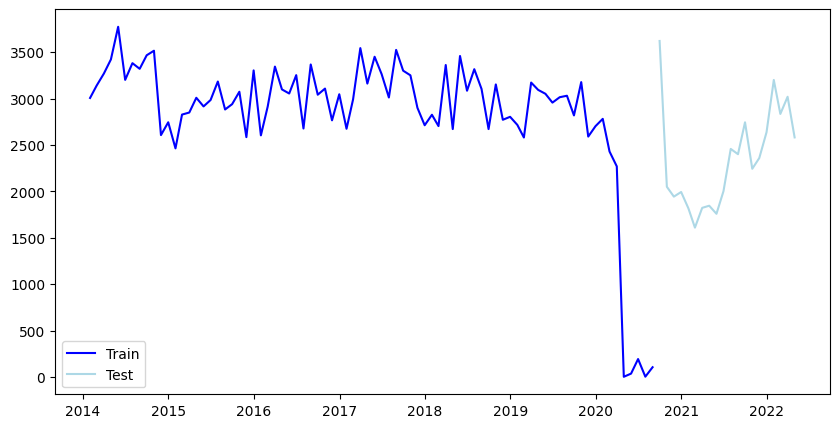

In [87]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_df['ds'], train_df['y'], color = "blue", label = "Train");
ax.plot(test_df['ds'], test_df['TotalReleases'], color = "lightblue", label = "Test");
ax.legend(loc="lower left");

Fit the model:

In [88]:
m = Prophet()
m.fit(train_df)

10:35:04 - cmdstanpy - INFO - Chain [1] start processing
10:35:04 - cmdstanpy - INFO - Chain [1] done processing


Make some predictions:

In [90]:
future = m.make_future_dataframe(periods = len(test_df.index), freq='M')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-31,3237.646442,2389.393724,4021.265169
1,2014-02-28,3342.988345,2576.361977,4162.348126
2,2014-03-31,3626.021582,2877.362839,4427.666216
3,2014-04-30,3277.283125,2494.577549,4071.702851
4,2014-05-31,3436.735807,2644.613260,4299.547567


Plot the forecast:

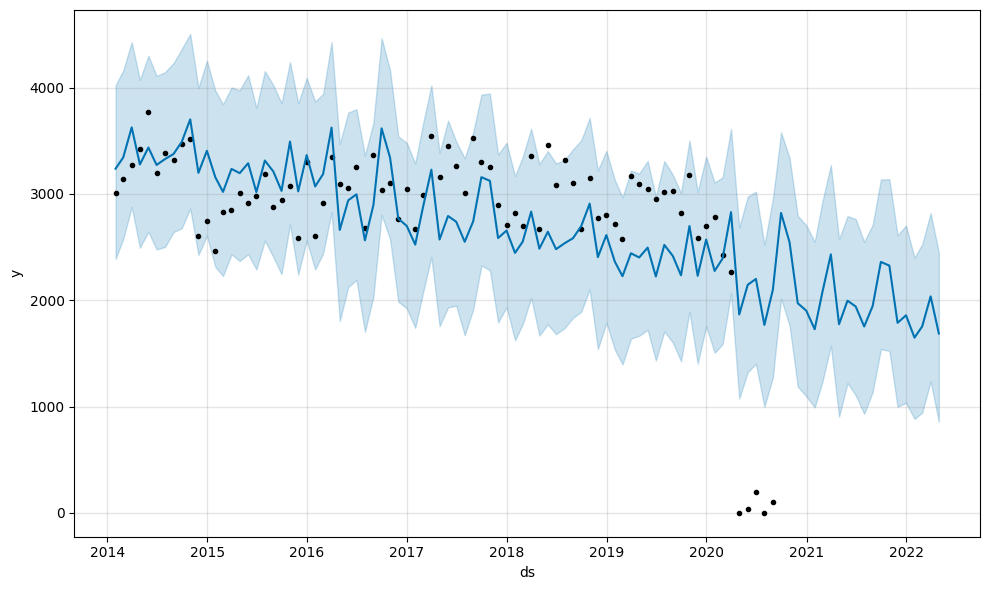

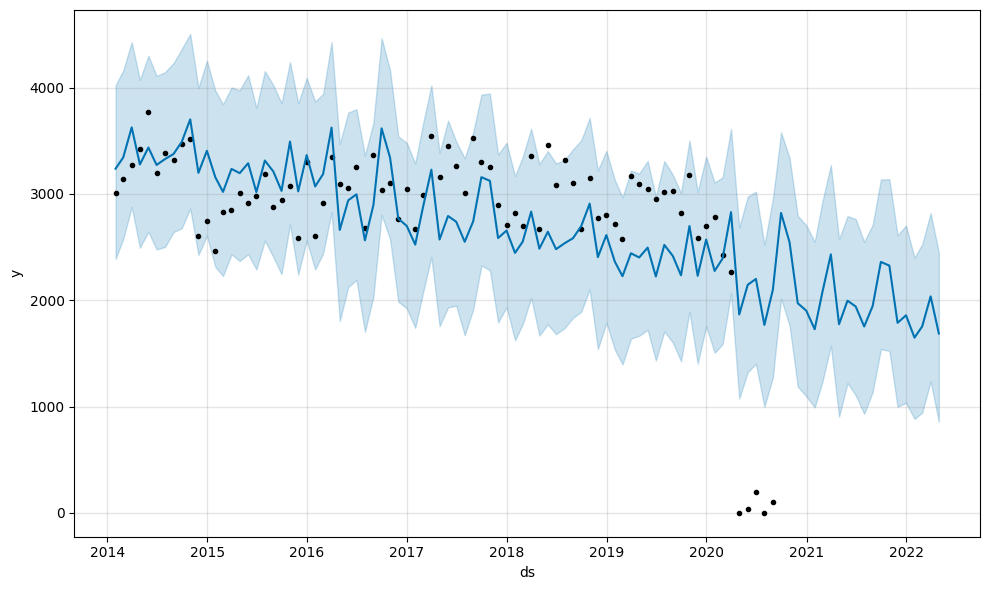

In [91]:
m.plot(forecast)

The dots represent actual data points, the line represents teh predicted values, and the shaded area represents the uncertainty interval.